# Memento Demo

## Imports

In [1]:
from twosigma.memento import memento_function
import time

## Set up a Demo Sandbox (not normally necessary)
Expand and run this section if you wish to sandbox and reset the memoization state

In [2]:
from twosigma.memento import list_memoized_functions, Environment, ConfigurationRepository, forget_cluster
import os
from pathlib import Path

demo_home = f"{os.path.expanduser('~')}/.memento/env/memento_demo"
Path.mkdir(Path(demo_home), parents=True, exist_ok=True)
Environment.set({"name": "memento_demo", "base_dir": demo_home})

In [3]:
forget_cluster()

## Hello, World
This demo shows caching in action. The function `hello` has an artificial 1 second delay which is clearly run the first time it encounters the "hello" input but not the second.

Calling the function with a different input incurs the delay again, as it is a unique computation.

In [4]:
@memento_function
def hello(n: str) -> str:
    print(f"Calculating for {n}...")
    time.sleep(1)
    return f"hello, {n}!"

In [5]:
hello("world")

Calculating for world...


'hello, world!'

In [6]:
hello("world")

'hello, world!'

In [7]:
hello("there")

Calculating for there...


'hello, there!'

Memento calculates a version of the function

In [8]:
v1 = hello.version()
v1

'a3170059eeed6797'

If we change the function, the version changes:

In [9]:
@memento_function
def hello(n: str) -> str:
    print(f"Calculating for {n}...")
    time.sleep(1)
    return f"Hello, {n.title()}!"  # Hello is captialized, and we use the title case for n as well

In [10]:
v2 = hello.version()
v2

'4b2ee18534d039f7'

In [11]:
hello("world")

Calculating for world...


'Hello, World!'

Now, if we change it back, the version goes back to what it was before

In [12]:
@memento_function
def hello(n: str) -> str:
    print(f"Calculating for {n}...")
    time.sleep(1)
    return f"hello, {n}!"

In [13]:
v3 = hello.version()
v3

'a3170059eeed6797'

In [14]:
v3 == v1

True

## Double and Add
This demo shows three functions, `increment(x)`, `double(x)`, and `increment_and_double(x)`

In [15]:
@memento_function
def increment(x):
    print(f"increment({x})")
    return x + 1

@memento_function
def double(x):
    print(f"double({x})")
    return x * 2

@memento_function
def increment_and_double(x):
    print(f"increment_and_double({x})")
    return double(increment(x))

Basic usage

In [16]:
increment(1)

increment(1)


2

In [17]:
double(2)

double(2)


4

Now, we call increment_and_double

In [18]:
increment_and_double(2)

increment_and_double(2)
increment(2)
double(3)


6

We can instruct Memento to graph the dependencies of `increment_and_double`, which it gets from static analysis of the code. This is the expected call graph (which can differ from the actual if branches are taken).

In [19]:
increment_and_double.dependencies()

We can introspect on the memento (the metadata artifact recorded when we called `increment_and_double(2)`)

In [20]:
increment_and_double.memento(2)

Memento(time=datetime.datetime(2024, 3, 31, 21, 13, 30, 18678, tzinfo=tzutc()), invocation_metadata=InvocationMetadata(fn_reference_with_args=FunctionReferenceWithArguments(fn_reference=FunctionReference('__main__:increment_and_double#eaa2b7f9012bc881', partial_args=(), partial_kwargs=None, external=False), args=(2,), kwargs={}, context_args={}), invocations=[FunctionReferenceWithArguments(fn_reference=FunctionReference('__main__:increment#b67215ccb618c9d0', partial_args=(), partial_kwargs=None, external=False), args=(2,), kwargs={}, context_args={}), FunctionReferenceWithArguments(fn_reference=FunctionReference('__main__:double#885a872da7be0a6d', partial_args=(), partial_kwargs=None, external=False), args=(3,), kwargs={}, context_args={})], runtime=datetime.timedelta(microseconds=4276), result_type=<ResultType.number: (5,)>), function_dependencies={FunctionReference('__main__:double#885a872da7be0a6d', partial_args=(), partial_kwargs=None, external=False), FunctionReference('__main__:i

We can ask Memento to show what it actually observed from the call graph:

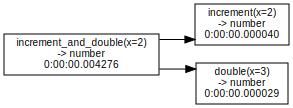

In [21]:
increment_and_double.memento(2).graph()

## Fizz Buzz Example
In this example, we implement Fizz Buzz, defined as follows:
```
Given an integer n, return a string array answer (1-indexed) where:

answer[i] == "FizzBuzz" if i is divisible by 3 and 5.
answer[i] == "Fizz" if i is divisible by 3.
answer[i] == "Buzz" if i is divisible by 5.
answer[i] == i (as a string) if none of the above conditions are true.
```

In [22]:
@memento_function
def fizz_buzz(n: int) -> list[str]:
    print(f"Calculating {n}")
    time.sleep(0.2)
    if n == 0:
        return []
    answer = ""
    if (n % 3) == 0:
        answer += "Fizz"
    if (n % 5) == 0:
        answer += "Buzz"
    return fizz_buzz(n-1) + [answer or str(n)]

In [23]:
fizz_buzz(1)

Calculating 1
Calculating 0


['1']

In [24]:
fizz_buzz(1)

['1']

In [25]:
fizz_buzz(5)

Calculating 5
Calculating 4
Calculating 3
Calculating 2


['1', '2', 'Fizz', '4', 'Buzz']

In [26]:
fizz_buzz(20)

Calculating 20
Calculating 19
Calculating 18
Calculating 17
Calculating 16
Calculating 15
Calculating 14
Calculating 13
Calculating 12
Calculating 11
Calculating 10
Calculating 9
Calculating 8
Calculating 7
Calculating 6


['1',
 '2',
 'Fizz',
 '4',
 'Buzz',
 'Fizz',
 '7',
 '8',
 'Fizz',
 'Buzz',
 '11',
 'Fizz',
 '13',
 '14',
 'FizzBuzz',
 '16',
 '17',
 'Fizz',
 '19',
 'Buzz']

In [27]:
m = fizz_buzz.memento(1)

In [28]:
sorted([m.invocation_metadata.fn_reference_with_args.args for m in fizz_buzz.list_mementos()])

[(0,),
 (1,),
 (2,),
 (3,),
 (4,),
 (5,),
 (6,),
 (7,),
 (8,),
 (9,),
 (10,),
 (11,),
 (12,),
 (13,),
 (14,),
 (15,),
 (16,),
 (17,),
 (18,),
 (19,),
 (20,)]

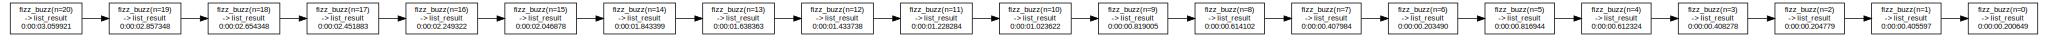

In [29]:
fizz_buzz.memento(20).graph()

In [30]:
fizz_buzz(15)

['1',
 '2',
 'Fizz',
 '4',
 'Buzz',
 'Fizz',
 '7',
 '8',
 'Fizz',
 'Buzz',
 '11',
 'Fizz',
 '13',
 '14',
 'FizzBuzz']